<a href="https://colab.research.google.com/github/bochendong/IdeasLab/blob/main/SplitMnist_80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.61MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]
2026-02-11 02:37:56,982 - INFO - ========== Training Task 0: classes [0, 1] ==========
2026-02-11 02:37:59,601 - INFO - [Task 0 | ep 0 | step 0] loss=41.8306 c=0.9867 d=40.8439 r=0.0000 | T0=98.65%
2026-02-11 02:38:02,448 - INFO - [Task 0 | ep 0 | step 25] loss=38.5827 c=0.0723 d=38.5104 r=0.0000 | T0=86.81%
2026-02-11 02:38:06,147 - INFO - [Task 0 | ep 0 | step 50] loss=35.7003 c=0.0558 d=35.6445 r=0.0000 | T0=99.40%
2026-02-11 02:38:08,870 - INFO - [Task 0 | ep 0 | step 75] loss=35.8080 c=0.0578 d=35.7501 r=0.0000 | T0=99.59%
2026-02-11 02:38:11,617 - INFO - [Task 0 | ep 1 | step 100] loss=35.3730 c=0.0613 d=35.3117 r=0.0000 | T0=98.83%
2026-02-11 02:38:15,268 - INFO - [Task 0 | ep 1 | step 125] loss=34.9641 c=0.0606 d=34.9035 r=0.0000 | T0=98.37%
2026-02-11 02:38:19,057 - INF

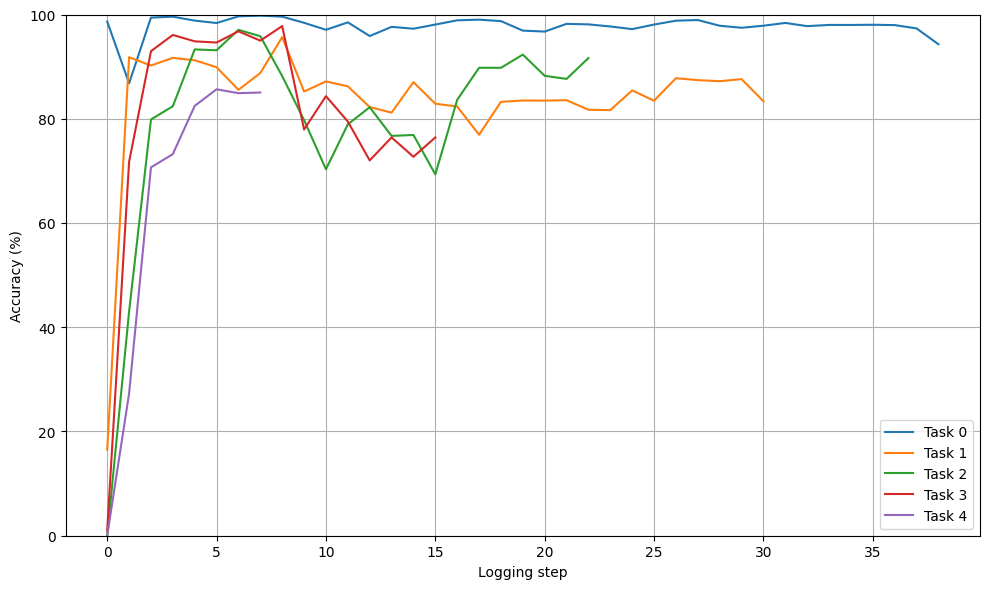

Done. Logs: ./output/split_mnist_meta_reg.log Plot: ./output/split_mnist_meta_reg_acc.png


2026-02-11 02:44:10,627 - INFO - ========== Training Task 0: classes [0, 1] ==========
2026-02-11 02:44:12,993 - INFO - [Task 0 | ep 0 | step 0] loss=41.8306 c=0.9867 d=40.8439 r=0.0000 | T0=98.65%
2026-02-11 02:44:15,798 - INFO - [Task 0 | ep 0 | step 25] loss=38.5827 c=0.0723 d=38.5104 r=0.0000 | T0=86.81%
2026-02-11 02:44:18,599 - INFO - [Task 0 | ep 0 | step 50] loss=35.7003 c=0.0558 d=35.6445 r=0.0000 | T0=99.40%
2026-02-11 02:44:22,284 - INFO - [Task 0 | ep 0 | step 75] loss=35.8080 c=0.0578 d=35.7501 r=0.0000 | T0=99.59%
2026-02-11 02:44:25,415 - INFO - [Task 0 | ep 1 | step 100] loss=35.3730 c=0.0613 d=35.3117 r=0.0000 | T0=98.83%
2026-02-11 02:44:28,209 - INFO - [Task 0 | ep 1 | step 125] loss=34.9641 c=0.0606 d=34.9035 r=0.0000 | T0=98.37%
2026-02-11 02:44:30,980 - INFO - [Task 0 | ep 1 | step 150] loss=34.8841 c=0.0630 d=34.8211 r=0.0000 | T0=99.64%
2026-02-11 02:44:34,413 - INFO - [Task 0 | ep 1 | step 175] loss=35.3029 c=0.0673 d=35.2357 r=0.0000 | T0=99.78%
2026-02-11 02:

In [1]:
# ===== Colab-ready Split MNIST Continual Learning (Meta-regularized) =====
import os
import copy
import math
import random
import logging
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torch.autograd import Function

# ------------------------
# Config
# ------------------------
BATCH_SIZE = 128
EPOCHS_PER_TASK = 2          # 你想复现原来就改回 4
LR = 5e-3
OUTPUT_DIR = "./output"
DISTRIBUTION_FACTOR = 15.0   # diff_loss 权重
META_LR = 1e-3
META_PRETRAIN_STEPS = 200    # 原来 400 太重了；想要就调大
SEED = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# ------------------------
# Logging
# ------------------------
def setup_logging(file_name):
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s",
        handlers=[logging.FileHandler(file_name), logging.StreamHandler()],
        force=True,
    )

# ------------------------
# Data
# ------------------------
tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

TASK_DIR = {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7], 4: [8, 9]}

def make_task_dataloader(task_num, train=True, batch_size=BATCH_SIZE):
    ds = datasets.MNIST(root="./data", train=train, download=True, transform=tf)
    labels = TASK_DIR[task_num]
    idx = [i for i, (_, y) in enumerate(ds) if y in labels]
    sub = Subset(ds, idx)
    # shuffle=True 更合理
    return DataLoader(sub, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2, pin_memory=True)

def build_all_task_loaders():
    loaders = {}
    for t in range(5):
        loaders[t] = (make_task_dataloader(t, train=True), make_task_dataloader(t, train=False))
    return loaders

TASK_LOADERS = build_all_task_loaders()

# ------------------------
# Utils
# ------------------------
@torch.no_grad()
def cal_acc(model, dataloader, device=DEVICE, valid_out_dim=None):
    model.eval()
    correct, total = 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        if valid_out_dim is not None:
            logits = logits[:, :valid_out_dim]
        pred = logits.argmax(dim=1)
        total += y.size(0)
        correct += (pred == y).sum().item()
    return correct / max(total, 1)

def plot_task_acc_history(history, save_path):
    """
    history: list, each element is dict {task_id: [acc1, acc2, ...]} recorded during training each task
    """
    plt.figure(figsize=(10,6))
    for task_id in range(5):
        # 拼接 task_id 在后续训练中每次记录的 acc
        series = []
        for trained_task_idx, d in enumerate(history):
            if task_id in d:
                series.extend(d[task_id])
            else:
                # 训练到更早任务时，不存在记录就不加
                pass
        if len(series) > 0:
            plt.plot(series, label=f"Task {task_id}")
    plt.xlabel("Logging step")
    plt.ylabel("Accuracy (%)")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# ------------------------
# Gradient Reversal
# ------------------------
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

# ------------------------
# Meta model (attention)
# ------------------------
class DeepModelWithAttention(nn.Module):
    """
    Input: diffs of shape [num_prev_tasks, batch, 2]
    Output: weights of shape [num_prev_tasks] (sum = desired_sum)
    """
    def __init__(self, desired_sum: float):
        super().__init__()
        self.desired_sum = desired_sum
        self.attn = nn.MultiheadAttention(embed_dim=2, num_heads=1, batch_first=True)
        self.fc = nn.Linear(2, 1)

    def forward(self, x, mode="eval"):
        # x: [T, B, 2] -> attention expects [B, T, 2] with batch_first=True
        x = x.transpose(0, 1)  # [B, T, 2]
        if mode == "train":
            x = ReverseLayerF.apply(x, 1.0)

        attn_out, _ = self.attn(x, x, x)  # [B, T, 2]
        attn_out = attn_out.mean(dim=0)   # [T, 2]
        scores = self.fc(attn_out).squeeze(-1)  # [T]
        weights = F.softmax(scores, dim=0) * self.desired_sum
        return weights  # [T]

# ------------------------
# Main model (MLP)
# ------------------------
class MLP_Enhance(nn.Module):
    def __init__(self, out_dim=10, in_channel=1, img_sz=28, hidden_dim=400):
        super().__init__()
        self.in_dim = in_channel * img_sz * img_sz
        self.backbone = nn.Sequential(
            nn.Linear(self.in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
        )
        # IMPORTANT: 输出 logits，不要 softmax
        self.head = nn.Linear(hidden_dim, out_dim)
        self.init_weights()

    def init_weights(self):
        for layer in self.backbone:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode="fan_out", nonlinearity="relu")
                init.constant_(layer.bias, 0)
        init.xavier_normal_(self.head.weight)
        init.constant_(self.head.bias, 0)

    def forward(self, x):
        x = x.view(-1, self.in_dim)
        feat = self.backbone(x)
        logits = self.head(feat)
        return logits

# ------------------------
# Losses
# ------------------------
def diff_loss(model, criterion, distribution_factor=DISTRIBUTION_FACTOR):
    # 随机噪声正则，让输出分布不过度坍塌
    x = torch.rand(256, 1, 28, 28, device=DEVICE)
    x = (x - 0.5) / 0.5
    y = torch.randint(0, 10, (256,), device=DEVICE)
    logits = model(x)
    return distribution_factor * criterion(logits, y)

def reg_loss(outputs_logits, meta_model, images, prev_models, task_num, mode="eval"):
    """
    outputs_logits: current model logits, [B, 10]
    prev_models: list of frozen models, length = task_num
    We compare only old task slices (2 classes each).
    """
    # Build diffs: [task_num, B, 2]
    diffs = []
    for k, prev_mod in enumerate(prev_models):
        with torch.no_grad():
            past_logits = prev_mod(images)
        # slice for task k => [2k, 2k+1]
        cur_slice = outputs_logits[:, 2*k:2*k+2]
        past_slice = past_logits[:, 2*k:2*k+2]
        diffs.append((past_slice - cur_slice).abs().unsqueeze(0))  # [1, B, 2]
    diffs = torch.cat(diffs, dim=0)  # [T, B, 2]

    # mean per task: [T]
    mean_diff = diffs.mean(dim=(1, 2))  # [T]

    if mode == "eval":
        with torch.no_grad():
            weights = meta_model(diffs, mode="eval")  # [T]
    else:
        weights = meta_model(diffs, mode="train")    # [T]

    return torch.sum(weights * mean_diff)

# ------------------------
# Meta pretrain
# ------------------------
def pretrain_meta(meta_model, optimizer_M, task_num, steps=META_PRETRAIN_STEPS):
    """
    让 meta_model 学会输出“总和为 2*task_num”的权重分配（只是一个 warm start）
    """
    meta_model.train()
    target = torch.full((task_num,), 2.0, device=DEVICE)  # 希望每个旧任务初始权重≈2
    criterion = nn.MSELoss()

    for _ in range(steps):
        # fake diffs: [T, B, 2]
        diffs = torch.rand(task_num, BATCH_SIZE, 2, device=DEVICE)
        out = meta_model(diffs, mode="eval")  # [T]
        loss = criterion(out, target)

        optimizer_M.zero_grad()
        loss.backward()
        optimizer_M.step()

# ------------------------
# Train one task
# ------------------------
def train_one_task(model, task_num, optimizer_F, criterion, prev_models, epochs=EPOCHS_PER_TASK, log_every=20):
    train_loader, _ = TASK_LOADERS[task_num]
    valid_out_dim = task_num * 2 + 2

    meta_model = None
    optimizer_M = None
    if task_num > 0:
        meta_model = DeepModelWithAttention(desired_sum=2 * task_num).to(DEVICE)
        optimizer_M = torch.optim.Adam(meta_model.parameters(), lr=META_LR)
        pretrain_meta(meta_model, optimizer_M, task_num)

    acc_log = {t: [] for t in range(task_num + 1)}
    step = 0

    for ep in range(epochs):
        for x, y in train_loader:
            model.train()
            x, y = x.to(DEVICE), y.to(DEVICE)

            logits = model(x)
            c_loss = criterion(logits[:, :valid_out_dim], y)

            d_loss = diff_loss(model, criterion, DISTRIBUTION_FACTOR)

            if task_num > 0:
                r_loss = reg_loss(logits, meta_model, x, prev_models, task_num, mode="eval")
            else:
                r_loss = torch.tensor(0.0, device=DEVICE)

            loss = c_loss + d_loss + r_loss

            optimizer_F.zero_grad()
            loss.backward()
            optimizer_F.step()

            # meta update
            if task_num > 0:
                model.eval()
                with torch.no_grad():
                    logits2 = model(x)
                meta_l = reg_loss(logits2, meta_model, x, prev_models, task_num, mode="train")
                optimizer_M.zero_grad()
                meta_l.backward()
                optimizer_M.step()

            if step % log_every == 0:
                msg = [f"[Task {task_num} | ep {ep} | step {step}] loss={loss.item():.4f} c={c_loss.item():.4f} d={d_loss.item():.4f} r={float(r_loss):.4f}"]
                for t in range(task_num + 1):
                    acc = cal_acc(model, TASK_LOADERS[t][0], DEVICE, valid_out_dim=(t*2+2))
                    acc_log[t].append(acc * 100.0)
                    msg.append(f"T{t}={acc*100:.2f}%")
                logging.info(" | ".join(msg))

            step += 1

    return acc_log

# ------------------------
# Full continual learning run
# ------------------------
def freeze_model(m: nn.Module):
    m.eval()
    for p in m.parameters():
        p.requires_grad = False
    return m

def train_split_mnist(run_name="run"):
    log_path = os.path.join(OUTPUT_DIR, f"{run_name}.log")
    setup_logging(log_path)

    model = MLP_Enhance().to(DEVICE)
    optimizer_F = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    prev_models = []
    history = []

    for task in range(5):
        logging.info(f"========== Training Task {task}: classes {TASK_DIR[task]} ==========")
        acc_log = train_one_task(model, task, optimizer_F, criterion, prev_models, epochs=EPOCHS_PER_TASK, log_every=25)
        history.append(acc_log)

        # 保存一个冻结的 copy 作为 teacher
        teacher = copy.deepcopy(model).to(DEVICE)
        teacher = freeze_model(teacher)
        prev_models.append(teacher)

        # 每个任务结束后评估所有已学任务
        eval_msg = [f"[After Task {task}]"]
        for t in range(task + 1):
            acc = cal_acc(model, TASK_LOADERS[t][1], DEVICE, valid_out_dim=(t*2+2))
            eval_msg.append(f"Test T{t}={acc*100:.2f}%")
        logging.info(" | ".join(eval_msg))

    fig_path = os.path.join(OUTPUT_DIR, f"{run_name}_acc.png")
    plot_task_acc_history(history, fig_path)
    print("Done. Logs:", log_path, "Plot:", fig_path)

# ------------------------
# Run
# ------------------------
train_split_mnist("split_mnist_meta_reg")
